In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# ==============================================================================
# 🚀 ÉTAPE 1: INSTALLATION DES OUTILS SPÉCIAUX
# ==============================================================================
# Pourquoi cette étape ? Kaggle nous donne un environnement de base, mais pour des
# tâches avancées comme l'optimisation (Optuna) ou le suivi d'expériences (Wandb),
# nous avons besoin d'outils supplémentaires. On les installe ici.

import subprocess
import sys

def install_package(package):
    """Une petite fonction pour installer un package Python proprement."""
    print(f"🔧 Tentative d'installation de l'outil '{package}'...")
    try:
        # On utilise pip, le gestionnaire de paquets de Python, pour installer.
        # Le '-q' signifie 'quiet' pour ne pas inonder la console de messages.
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✅ L'outil '{package}' a été installé avec succès !")
    except Exception as e:
        print(f"❌ Oups, une erreur est survenue lors de l'installation de {package}: {e}")
        print("   Le notebook continuera, mais certaines fonctionnalités pourraient manquer.")

# La liste des outils dont nous avons besoin.
packages_to_install = [
    "optuna==3.4.0",       # Pour l'optimisation automatique des hyperparamètres.
    "torch-fidelity==0.3.0", # Pour calculer le score FID, une métrique de qualité d'image.
    "wandb==0.15.0"          # Pour visualiser nos entraînements (optionnel).
]

print("=" * 60)
print("🚀 DÉBUT DE L'INSTALLATION DES DÉPENDANCES")
print("=" * 60)

for package in packages_to_install:
    install_package(package)

# ==============================================================================
# 📦 ÉTAPE 2: IMPORTS ET VÉRIFICATIONS
# ==============================================================================
# Maintenant que les outils sont installés, on les "charge" dans notre script
# pour pouvoir les utiliser. C'est comme sortir les outils de leur boîte.

print("\n" + "=" * 60)
print("📦 CHARGEMENT DES BIBLIOTHÈQUES ET VÉRIFICATION DE L'ENVIRONNEMENT")
print("=" * 60)

# Imports principaux
print("Chargement des bibliothèques de base...")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import logging
import json
import traceback
from pathlib import Path
from typing import Dict, Any, Optional, Tuple, List
import random
import time
from datetime import datetime
import warnings

# On ignore les avertissements pour garder la sortie propre.
warnings.filterwarnings('ignore')
print("✅ Bibliothèques de base chargées.")

# Vérifications détaillées de l'environnement
print("\n🔍 VÉRIFICATION DE L'ENVIRONNEMENT DE TRAVAIL:")
print(f"   📊 Version de PyTorch: {torch.__version__} (la bibliothèque principale pour le Deep Learning)")
print(f"   📊 Version de Torchvision: {torchvision.__version__} (contient les datasets et modèles pour la vision par ordinateur)")
print(f"   📊 Version de NumPy: {np.__version__} (pour les calculs mathématiques efficaces)")

# Vérification du GPU (c'est crucial pour la vitesse !)
print("\n🔍 Vérification de la carte graphique (GPU)...")
if torch.cuda.is_available():
    print(f"   ✅🎮 Bonne nouvelle ! CUDA est disponible. Vous avez {torch.cuda.device_count()} GPU(s) !")
    # CUDA est la technologie de NVIDIA qui permet d'utiliser les GPU pour les calculs.
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"      GPU {i}: {props.name}")
        print(f"         Mémoire totale: {props.total_memory / 1024**3:.2f} GB")
        # C'est la mémoire disponible sur la carte graphique, très importante pour les gros modèles.
else:
    print("   ⚠️ CUDA n'est pas disponible. Le code s'exécutera sur le CPU (processeur central).")
    print("      Ce sera BEAUCOUP plus lent. Sur Kaggle, assurez-vous d'activer l'accélérateur GPU dans les paramètres du notebook.")

# Vérification des imports spéciaux
print("\n🔍 Vérification des outils spéciaux installés...")
try:
    import optuna
    print(f"   ✅ Optuna (version {optuna.__version__}) est prêt pour l'optimisation.")
except ImportError:
    print("   ❌ Optuna n'a pas pu être importé.")

try:
    import torch_fidelity
    print("   ✅ torch-fidelity est prêt pour calculer un score de qualité (FID) précis.")
except ImportError:
    print("   ⚠️ torch-fidelity non disponible. On utilisera une métrique de qualité 'proxy' (une approximation).")

try:
    import wandb
    print(f"   ✅ Wandb (version {wandb.__version__}) est prêt pour le suivi.")
except ImportError:
    print("   ⚠️ Wandb non disponible. Pas de suivi externe des expériences.")

print("\n🎉 Tout est prêt ! L'environnement est configuré.")

🚀 DÉBUT DE L'INSTALLATION DES DÉPENDANCES
🔧 Tentative d'installation de l'outil 'optuna==3.4.0'...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.6 MB/s eta 0:00:00
✅ L'outil 'optuna==3.4.0' a été installé avec succès !
🔧 Tentative d'installation de l'outil 'torch-fidelity==0.3.0'...
✅ L'outil 'torch-fidelity==0.3.0' a été installé avec succès !
🔧 Tentative d'installation de l'outil 'wandb==0.15.0'...
✅ L'outil 'wandb==0.15.0' a été installé avec succès !

📦 CHARGEMENT DES BIBLIOTHÈQUES ET VÉRIFICATION DE L'ENVIRONNEMENT
Chargement des bibliothèques de base...
✅ Bibliothèques de base chargées.

🔍 VÉRIFICATION DE L'ENVIRONNEMENT DE TRAVAIL:
   📊 Version de PyTorch: 2.6.0+cu124 (la bibliothèque principale pour le Deep Learning)
   📊 Version de Torchvision: 0.21.0+cu124 (contient les datasets et modèles pour la vision par ordinateur)
   📊 Version de NumPy: 1.26.4 (pour les calculs mathématiques efficaces)

🔍 Vérification de la carte graphique (GPU)...
   ⚠️ CUDA n'est pas di

In [14]:
from dataclasses import dataclass, field

@dataclass
class ExperimentConfig:
    """
    Une classe pour centraliser TOUS les paramètres de notre expérience.
    C'est comme le tableau de bord de notre projet. On peut tout changer ici.
    Le '@dataclass' est une astuce Python pour créer des classes de stockage
    de données simplement.
    """
    
    # --- Paramètres de base de l'expérience ---
    print("Définition de la classe de configuration...")
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    dataset_path: str = "/kaggle/working/datasets"  # Chemin standard sur Kaggle pour les données.
    output_dir: str = "/kaggle/working/experiments" # Chemin où sauvegarder nos résultats.
    img_size: int = 32                   # Taille des images (en pixels, ex: 32x32).
    img_channels: int = 3                # Nombre de canaux de couleur (3 pour RGB, 1 pour noir et blanc).
    dataset_name: str = "cifar10"        # Le nom du dataset à utiliser ('cifar10' ou 'mnist').
    
    # --- Plages d'hyperparamètres (pour l'optimisation future) ---
    # Ce sont les "boutons" que l'on pourrait tourner pour trouver la meilleure recette.
    batch_size_range: Tuple[int, int] = (32, 64)  # Taille des lots d'images. Réduit pour Kaggle pour éviter les erreurs de mémoire.
    latent_dim_range: Tuple[int, int] = (64, 128) # Dimension de l'espace latent (le "bruit" de départ du générateur).
    lr_range: Tuple[float, float] = (1e-4, 1e-3)  # Plage du taux d'apprentissage (learning rate).
    beta1_range: Tuple[float, float] = (0.4, 0.6) # Paramètre de l'optimiseur Adam.
    beta2_range: Tuple[float, float] = (0.9, 0.999)# Autre paramètre d'Adam.
    
    # --- Choix des architectures de modèles ---
    generator_architectures: List[str] = field(default_factory=lambda: ['dcgan'])
    discriminator_architectures: List[str] = field(default_factory=lambda: ['dcgan'])
    
    # --- Paramètres d'entraînement (réduits pour un test rapide sur Kaggle) ---
    max_epochs: int = 10                  # Nombre maximum de fois où l'on parcourt tout le dataset.
    early_stopping_patience: int = 5      # Arrêter si le score ne s'améliore pas après X époques.
    n_trials: int = 3                     # Nombre d'essais pour l'optimisation (très réduit pour le test).
    
    # --- Suivi et Sauvegarde ---
    seed: int = 42                        # Un nombre fixe pour l'aléatoire, pour des résultats reproductibles.
    use_wandb: bool = False               # Activer/désactiver le suivi avec Wandb.
    save_interval: int = 2                # Sauvegarder le meilleur modèle toutes les X époques.
    eval_interval: int = 2                # Évaluer la qualité des images toutes les X époques.
    
    # --- Paramètres de la métrique FID (qualité) ---
    fid_batch_size: int = 32
    num_fid_samples: int = 256            # Nombre d'images à générer pour l'évaluation (réduit pour la vitesse).
    
    # --- Gestion de la performance et de la mémoire ---
    cleanup_memory: bool = True           # Tenter de libérer la mémoire GPU régulièrement.
    use_mixed_precision: bool = True      # Utiliser une technique pour accélérer l'entraînement sur les GPU récents.
    
    # --- Paramètres de débogage ---
    debug_mode: bool = True               # Activer les messages de débogage supplémentaires.
    verbose_training: bool = False        # Activer les prints à l'intérieur de la boucle d'entraînement (peut être très verbeux).
    
    def __post_init__(self):
        """Cette fonction est appelée juste après la création d'un objet ExperimentConfig."""
        print("\n🔧 CONFIGURATION EN COURS D'INITIALISATION...")
        print("   Vérification et ajustement des paramètres fournis.")
        print(f"   -> Dataset demandé: {self.dataset_name} (taille {self.img_size}x{self.img_size})")
        print(f"   -> Appareil de calcul: '{self.device}'")
        print(f"   -> Mode debug activé: {'Oui' if self.debug_mode else 'Non'}")
        
        # Validation des entrées
        if self.img_size not in [32, 64, 128]:
            raise ValueError(f"Erreur ! La taille d'image {self.img_size} n'est pas supportée. Choix : [32, 64, 128].")
        
        if self.dataset_name not in ['cifar10', 'mnist']:
            raise ValueError(f"Erreur ! Le dataset '{self.dataset_name}' n'est pas supporté. Choix : ['cifar10', 'mnist'].")
        
        # Ajustement automatique
        if self.dataset_name == 'mnist' and self.img_channels != 1:
            print(f"   -> INFO: Le dataset MNIST est en noir et blanc. Passage automatique des canaux de {self.img_channels} à 1.")
            self.img_channels = 1
        
        # Création du dossier de sortie
        Path(self.output_dir).mkdir(parents=True, exist_ok=True)
        print(f"   -> Le dossier pour les résultats '{self.output_dir}' est prêt.")
        print("✅ Initialisation de la configuration terminée.")

def set_seed(seed: int):
    """
    Une fonction pour "fixer" toutes les sources d'aléatoire dans notre code.
    Pourquoi ? Pour la REPRODUCTIBILITÉ. Si on relance ce notebook, on obtiendra
    exactement les mêmes résultats, ce qui est crucial pour le débogage et la science.
    """
    print(f"\n🌱 FIXATION DE LA GRAINE ALÉATOIRE (SEED) à {seed}...")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # Pour les GPU
    np.random.seed(seed)
    random.seed(seed)
    # Ces deux lignes assurent un comportement déterministe de la part de CUDA.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("✅ Toutes les sources d'aléatoire sont maintenant contrôlées.")

def cleanup_gpu_memory():
    """
    Une fonction pour demander à PyTorch de faire le ménage dans la mémoire du GPU.
    Parfois, des tenseurs inutilisés restent en mémoire. Cette fonction aide à les libérer.
    """
    if torch.cuda.is_available():
        print("🧹 Tentative de nettoyage de la mémoire GPU...")
        before = torch.cuda.memory_allocated()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        after = torch.cuda.memory_allocated()
        print(f"   -> Mémoire libérée: {(before - after) / 1024**2:.2f} MB")
    
    import gc
    gc.collect() # Fait aussi le ménage dans la mémoire standard (RAM).

def setup_logging(verbose: bool = False):
    """Configure le système de logging pour afficher des messages clairs."""
    print("\n📝 CONFIGURATION DU SYSTÈME DE LOGGING...")
    level = logging.DEBUG if verbose else logging.INFO
    logging.basicConfig(level=level, format='%(asctime)s | %(levelname)s | %(message)s', datefmt='%H:%M:%S', force=True)
    print(f"✅ Logging configuré. Niveau de détail: {'DEBUG (très verbeux)' if verbose else 'INFO (normal)'}.")

# ==============================================================================
# 🚀 INITIALISATION PRINCIPALE
# ==============================================================================
print("\n" + "=" * 60)
print("⚙️ DÉMARRAGE DE LA CONFIGURATION GLOBALE")
print("=" * 60)

# On crée notre objet de configuration. C'est ici que tout commence !
config = ExperimentConfig()

# On fixe la graine aléatoire.
set_seed(config.seed)

# On configure le logging.
setup_logging(config.debug_mode)

print("\n🎉 Configuration et setup terminés avec succès ! Prêts pour la suite.")

Définition de la classe de configuration...

⚙️ DÉMARRAGE DE LA CONFIGURATION GLOBALE

🔧 CONFIGURATION EN COURS D'INITIALISATION...
   Vérification et ajustement des paramètres fournis.
   -> Dataset demandé: cifar10 (taille 32x32)
   -> Appareil de calcul: 'cpu'
   -> Mode debug activé: Oui
   -> Le dossier pour les résultats '/kaggle/working/experiments' est prêt.
✅ Initialisation de la configuration terminée.

🌱 FIXATION DE LA GRAINE ALÉATOIRE (SEED) à 42...
✅ Toutes les sources d'aléatoire sont maintenant contrôlées.

📝 CONFIGURATION DU SYSTÈME DE LOGGING...
✅ Logging configuré. Niveau de détail: DEBUG (très verbeux).

🎉 Configuration et setup terminés avec succès ! Prêts pour la suite.


In [4]:
# ==============================================================================
# 🛠️ CELLULE 3: NOTRE BOÎTE À OUTILS (UTILITAIRES ET HELPERS)
# ==============================================================================
# Ici, on définit des fonctions "aides" pour nous faciliter la vie.

print("=" * 60)
print("🛠️ CHARGEMENT DE LA BOÎTE À OUTILS")
print("=" * 60)


def print_tensor_info(tensor, name="Tensor"):
    """
    Affiche un rapport de santé complet pour un tenseur PyTorch.
    Un "tenseur" est la brique de base de PyTorch, c'est comme un tableau
    multi-dimensionnel (un vecteur, une matrice, ou plus).
    Cette fonction est notre "scanner" pour voir ce qu'il y a à l'intérieur.
    """
    print(f"\n--- 📊 Rapport d'information pour le tenseur : '{name}' ---")
    if not isinstance(tensor, torch.Tensor):
        print(f"   -> ERREUR: L'objet fourni n'est pas un tenseur PyTorch, mais un {type(tensor)}.")
        return
        
    print(f"   -> Forme (Shape): {tensor.shape}")
    # La forme nous dit combien d'éléments il y a dans chaque dimension. Ex: [64, 3, 32, 32] -> 64 images, 3 canaux, 32x32 pixels.
    print(f"   -> Type de données (Dtype): {tensor.dtype}")
    # Le type de données (ex: float32) nous dit comment les nombres sont stockés. Crucial pour la précision et la mémoire.
    print(f"   -> Appareil (Device): {tensor.device}")
    # Nous dit si le tenseur est sur le CPU ou le GPU. Les calculs ne peuvent se faire qu'entre tenseurs sur le même appareil.
    print(f"   -> Valeurs (Min / Max): {tensor.min().item():.4f} / {tensor.max().item():.4f}")
    # .item() extrait la valeur d'un tenseur à 1 seul élément.
    print(f"   -> Statistiques (Moyenne / Écart-type): {tensor.mean().item():.4f} / {tensor.std().item():.4f}")
    # Très utile pour voir si nos données sont bien "normalisées".
    print(f"   -> Nécessite un gradient (Requires grad): {'✅ Oui' if tensor.requires_grad else '❌ Non'}")
    # Si 'Oui', PyTorch va calculer la dérivée (gradient) pour ce tenseur pendant l'entraînement. C'est essentiel pour les poids du modèle.
    print("----------------------------------------------------")


def print_model_info(model, model_name="Model"):
    """Affiche un résumé d'un modèle (Générateur ou Discriminateur)."""
    print(f"\n--- 🏗️ Carte d'identité du modèle : '{model_name}' ---")
    if not isinstance(model, nn.Module):
        print(f"   -> ERREUR: L'objet fourni n'est pas un modèle PyTorch (nn.Module), mais un {type(model)}.")
        return

    # Calcul des paramètres. Un "paramètre" est un poids que le modèle apprend.
    total_params = sum(p.numel() for p in model.parameters()) # p.numel() donne le nombre d'éléments dans un tenseur.
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"   -> Type d'architecture: {type(model).__name__}")
    print(f"   -> Nombre total de paramètres: {total_params:,}") # La virgule est une astuce pour formater les grands nombres.
    print(f"   -> Nombre de paramètres entraînables: {trainable_params:,}")
    # En général, ces deux nombres sont identiques, sauf si on "gèle" certaines couches.
    print(f"   -> Taille estimée en mémoire: {total_params * 4 / 1024**2:.2f} MB (en float32)")
    
    try:
        device = next(model.parameters()).device
        print(f"   -> Appareil (Device): Le modèle est sur le '{device}'")
    except StopIteration:
        print(f"   -> Appareil (Device): Le modèle n'a pas de paramètres, donc pas d'appareil défini.")
    
    print(f"   -> Mode actuel: {'🏃 Entraînement (Training)' if model.training else '🔍 Évaluation (Evaluation)'}")
    # C'est très important ! Certains couches comme le Dropout ou la BatchNorm se comportent différemment dans ces deux modes.
    print("-------------------------------------------------")


def plot_images(images, title="Images", nrow=8, figsize=(12, 6)):
    """Affiche une grille d'images (tenseurs) à l'aide de Matplotlib."""
    print(f"\n🖼️ PRÉPARATION DE L'AFFICHAGE D'IMAGES: '{title}'")
    
    if not isinstance(images, torch.Tensor):
        print(f"   -> ERREUR: La fonction attend un tenseur d'images, mais a reçu un {type(images)}.")
        return

    print(f"   -> Nombre d'images à afficher: {images.shape[0]}")
    print_tensor_info(images, "Tenseur d'images en entrée de plot_images")
    
    # Dénormalisation: nos images sont souvent normalisées entre -1 et 1. Pour les afficher, on doit les ramener entre 0 et 1.
    if images.min() < -0.1:  # Une petite marge pour les erreurs de floating point.
        print("   -> Dénormalisation détectée. Conversion des valeurs de [-1, 1] vers [0, 1] pour l'affichage.")
        images = (images + 1) / 2
    
    # Clamp: On s'assure que toutes les valeurs sont bien entre 0 et 1.
    images = torch.clamp(images, 0, 1)
    
    # On ne montre qu'un sous-ensemble si il y a trop d'images.
    if images.shape[0] > nrow * 2: # Ex: si on a plus de 2 lignes de 8 images
        images = images[:nrow * 2]
        print(f"   -> Trop d'images. Affichage des {images.shape[0]} premières seulement.")
    
    plt.figure(figsize=figsize)
    
    # torchvision a une super fonction pour créer une grille d'images.
    from torchvision.utils import make_grid
    print("   -> Création de la grille d'images avec 'make_grid'...")
    grid = make_grid(images, nrow=nrow, padding=2, normalize=False)
    
    # Matplotlib attend les canaux de couleur en dernière dimension (Hauteur, Largeur, Canaux),
    # alors que PyTorch les met en première (Canaux, Hauteur, Largeur). On doit donc permuter.
    print("   -> Permutation des dimensions pour compatibilité avec Matplotlib...")
    if grid.shape[0] == 1: # Image en noir et blanc
        plt.imshow(grid.squeeze().cpu(), cmap='gray')
    else: # Image en couleur
        plt.imshow(grid.permute(1, 2, 0).cpu())
    
    plt.title(title, fontsize=16)
    plt.axis('off') # On enlève les axes moches.
    plt.tight_layout()
    plt.show() # Affiche la figure !
    
    print(f"✅ Affichage '{title}' terminé.")

print("✅ Boîte à outils chargée. Fonctions prêtes à l'emploi !")

🛠️ CHARGEMENT DE LA BOÎTE À OUTILS
✅ Boîte à outils chargée. Fonctions prêtes à l'emploi !


In [5]:
# ==============================================================================
# 🏗️ CELLULE 4: PLANS DE CONSTRUCTION DE NOS MODÈLES (ARCHITECTURES)
# ==============================================================================
print("=" * 60)
print("🏗️ DÉFINITION DES ARCHITECTURES DES MODÈLES (GÉNÉRATEUR ET DISCRIMINATEUR)")
print("=" * 60)

import math

# --- Le Générateur ---

class BaseGenerator(nn.Module):
    """Classe de base pour tous nos générateurs. Contient la logique commune."""
    def __init__(self, latent_dim: int, img_channels: int, img_size: int):
        super().__init__() # Appel obligatoire au constructeur de la classe mère (nn.Module).
        print(f"\n--- [BaseGenerator] Initialisation d'un squelette de générateur ---")
        self.latent_dim = latent_dim
        self.img_channels = img_channels
        self.img_size = img_size
        print(f"   -> Objectif: créer des images de {img_size}x{img_size} pixels avec {img_channels} canaux.")
        print(f"   -> Point de départ: un vecteur de bruit de taille {latent_dim}.")
        # Validation des paramètres pour éviter les erreurs plus tard.
        if img_size not in [32, 64, 128]: raise ValueError(f"Taille d'image non supportée: {img_size}")
        if not (16 <= latent_dim <= 512): raise ValueError(f"Dimension latente non supportée: {latent_dim}")
        print("   -> Validation des paramètres de base OK.")

class DCGANGenerator(BaseGenerator):
    """
    Une implémentation de l'architecture DCGAN (Deep Convolutional GAN).
    C'est une architecture classique et robuste pour commencer.
    Elle utilise des convolutions "transposées" pour passer d'un petit vecteur de bruit
    à une grande image. C'est comme un processus de "dé-convolution".
    """
    def __init__(self, latent_dim: int, img_channels: int, img_size: int):
        # On appelle d'abord le constructeur de la classe de base.
        super().__init__(latent_dim, img_channels, img_size)
        print(f"--- [DCGANGenerator] Construction d'un générateur de type DCGAN ---")
        
        # Calcul dynamique des couches en fonction de la taille de l'image.
        n_layers = int(math.log2(img_size)) - 2
        self.init_size = img_size // (2 ** n_layers)
        print(f"   -> Pour une image de {img_size}px, nous utiliserons {n_layers} blocs de 'upsampling'.")
        print(f"   -> Le tenseur initial aura une taille spatiale de {self.init_size}x{self.init_size}.")
        
        # 1. Projection Linéaire: On transforme le vecteur de bruit initial en un volume 3D.
        num_features_proj = 256 * self.init_size ** 2
        print(f"   -> Création de la couche de projection: transforme {latent_dim} -> {num_features_proj} features.")
        self.projection = nn.Sequential(
            nn.Linear(latent_dim, num_features_proj),
            nn.BatchNorm1d(num_features_proj), # Normalise pour stabiliser l'entraînement.
            nn.ReLU(inplace=True)               # Fonction d'activation non-linéaire.
        )
        
        # 2. Blocs de Convolution Transposée: La partie "artistique" qui agrandit l'image.
        print("   -> Construction des blocs de convolution transposée...")
        layers = []
        in_channels = 256
        for i in range(n_layers - 1):
            out_channels = in_channels // 2
            print(f"      -> Bloc {i+1}: {in_channels} canaux -> {out_channels} canaux.")
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(True))
            in_channels = out_channels
        
        # Couche finale pour arriver à la bonne taille et au bon nombre de canaux.
        print(f"      -> Bloc final: {in_channels} canaux -> {img_channels} canaux (couleurs de l'image).")
        layers.append(nn.ConvTranspose2d(in_channels, img_channels, 4, 2, 1, bias=False))
        layers.append(nn.Tanh()) # Tanh met les valeurs entre -1 et 1, ce qui est une bonne pratique.
        self.conv_blocks = nn.Sequential(*layers)
        
        print(f"✅ [DCGANGenerator] Construction terminée.")
        print_model_info(self, "Générateur DCGAN fraîchement créé")

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Le 'forward pass': le chemin que les données suivent à travers le modèle."""
        # 'z' est notre vecteur de bruit en entrée.
        x = self.projection(z)
        x = x.view(x.size(0), 256, self.init_size, self.init_size) # On le redimensionne en un volume 3D.
        output = self.conv_blocks(x)
        return output

# --- Le Discriminateur ---

class BaseDiscriminator(nn.Module):
    """Classe de base pour tous nos discriminateurs."""
    def __init__(self, img_channels: int, img_size: int):
        super().__init__()
        print(f"\n--- [BaseDiscriminator] Initialisation d'un squelette de discriminateur ---")
        self.img_channels = img_channels
        self.img_size = img_size
        print(f"   -> Objectif: analyser une image de {img_size}x{img_size} et sortir un score de 'réalité'.")
        if img_size not in [32, 64, 128]: raise ValueError(f"Taille d'image non supportée: {img_size}")
        print("   -> Validation des paramètres de base OK.")

class DCGANDiscriminator(BaseDiscriminator):
    """
    Le critique d'art DCGAN. Il prend une image et essaie de la réduire
    à un seul nombre: la probabilité qu'elle soit réelle. Il utilise des
    convolutions classiques pour extraire des caractéristiques de l'image.
    """
    def __init__(self, img_channels: int, img_size: int):
        super().__init__(img_channels, img_size)
        print(f"--- [DCGANDiscriminator] Construction d'un discriminateur de type DCGAN ---")
        
        n_layers = int(math.log2(img_size)) - 2
        print(f"   -> Pour une image de {img_size}px, nous utiliserons {n_layers} blocs de 'downsampling'.")

        layers = []
        in_channels = img_channels
        out_channels = 64
        print("   -> Construction des blocs de convolution...")
        # Premier bloc sans normalisation.
        print(f"      -> Bloc 1: {in_channels} canaux -> {out_channels} canaux.")
        layers.append(nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        # Blocs intermédiaires
        for i in range(n_layers - 1):
            in_channels = out_channels
            out_channels *= 2
            print(f"      -> Bloc {i+2}: {in_channels} canaux -> {out_channels} canaux.")
            layers.append(nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        # Couche finale pour la décision.
        print(f"      -> Couche de décision finale.")
        layers.append(nn.Conv2d(out_channels, 1, kernel_size=img_size // (2**n_layers), stride=1, padding=0, bias=False))
        # La sortie est un seul nombre (un score), on n'utilise pas de Tanh ou Sigmoid ici car
        # la fonction de perte `BCEWithLogitsLoss` est plus stable numériquement et l'inclut déjà.
        
        self.model = nn.Sequential(*layers)
        
        print(f"✅ [DCGANDiscriminator] Construction terminée.")
        print_model_info(self, "Discriminateur DCGAN fraîchement créé")

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        """Le 'forward pass' du critique d'art."""
        return self.model(img)

# --- Les "Usines" à Modèles (Factories) ---
# Ce sont des fonctions qui construisent le bon modèle en fonction d'un nom.
# C'est plus propre que d'avoir des 'if/else' partout dans le code d'entraînement.

def create_generator(arch_name: str, latent_dim: int, img_channels: int, img_size: int):
    print(f"\n🏭 USINE À GÉNÉRATEURS: Demande de création d'un générateur '{arch_name}'...")
    if arch_name == 'dcgan':
        return DCGANGenerator(latent_dim, img_channels, img_size)
    else:
        raise ValueError(f"Architecture de générateur inconnue: {arch_name}")

def create_discriminator(arch_name: str, img_channels: int, img_size: int):
    print(f"\n🏭 USINE À DISCRIMINATEURS: Demande de création d'un discriminateur '{arch_name}'...")
    if arch_name == 'dcgan':
        return DCGANDiscriminator(img_channels, img_size)
    else:
        raise ValueError(f"Architecture de discriminateur inconnue: {arch_name}")

print("\n🎉 Plans de construction des modèles et usines prêts !")

🏗️ DÉFINITION DES ARCHITECTURES DES MODÈLES (GÉNÉRATEUR ET DISCRIMINATEUR)

🎉 Plans de construction des modèles et usines prêts !


In [6]:
# ==============================================================================
# 📊 CELLULE 5: NOTRE EXPERT EN QUALITÉ D'IMAGE (MÉTRIQUES ET FID)
# ==============================================================================
# Cette cellule définit les outils pour mesurer la qualité des images générées.

print("=" * 60)
print("📊 CHARGEMENT DES OUTILS D'ÉVALUATION DE LA QUALITÉ")
print("=" * 60)

from scipy.linalg import sqrtm

class FIDCalculator:
    """
    Notre expert en évaluation de la qualité des images.
    Il peut calculer une métrique "proxy" rapide ou, si possible, le vrai score FID.
    """
    
    def __init__(self, device: torch.device, batch_size: int = 32):
        print("\n--- [FIDCalculator] Initialisation de l'expert en qualité d'image ---")
        self.device = device
        self.batch_size = batch_size
        print(f"   -> L'expert utilisera l'appareil '{device}' avec des lots de {batch_size}.")
        
        # On vérifie si notre outil de pro, `torch-fidelity`, est disponible.
        self.use_torch_fidelity = 'torch_fidelity' in sys.modules
        if self.use_torch_fidelity:
            print("   -> ✅ L'outil 'torch-fidelity' est disponible. Le calcul du vrai score FID sera possible.")
        else:
            print("   -> ⚠️ L'outil 'torch-fidelity' n'est pas disponible. On utilisera une métrique 'proxy' (approximation).")
            # Si `torch_fidelity` n'est pas là, on charge notre propre modèle Inception
            # pour la métrique proxy. C'est un modèle pré-entraîné très bon pour "voir" les images.
            self._load_inception_model_for_proxy()

    def _load_inception_model_for_proxy(self):
        """Charge le modèle Inception-v3, nécessaire pour notre métrique proxy."""
        print("      -> [Proxy] Chargement du modèle Inception-v3 pour l'évaluation de la qualité...")
        try:
            from torchvision.models import inception_v3
            self.inception_model = inception_v3(pretrained=True, transform_input=False).to(self.device)
            # On retire la dernière couche de classification, on ne veut que les "features" (caractéristiques de l'image).
            self.inception_model.fc = nn.Identity() 
            self.inception_model.eval() # On le met en mode évaluation.
            print("      -> [Proxy] ✅ Modèle Inception-v3 chargé avec succès.")
        except Exception as e:
            print(f"      -> [Proxy] ❌ Erreur lors du chargement d'Inception-v3: {e}. La métrique proxy sera moins précise.")
            self.inception_model = None
            
    def _get_inception_features(self, images: torch.Tensor) -> torch.Tensor:
        """Passe les images à travers Inception pour en extraire les caractéristiques."""
        print(f"         -> [Proxy] Extraction des caractéristiques Inception pour {images.shape[0]} images...")
        if self.inception_model is None:
            print("         -> [Proxy] ⚠️ Modèle Inception non disponible, retour de caractéristiques nulles.")
            return torch.zeros(images.shape[0], 2048, device=self.device) # 2048 est la taille des features d'Inception

        # Inception attend des images de taille 299x299. On redimensionne si besoin.
        if images.shape[-1] != 299:
             images = nn.functional.interpolate(images, size=299, mode='bilinear', align_corners=False)
        
        with torch.no_grad(): # Pas besoin de gradients ici.
            features = self.inception_model(images)
        print(f"         -> [Proxy] ✅ Caractéristiques extraites. Forme: {features.shape}")
        return features

    def calculate_fid_proxy(self, fake_images: torch.Tensor) -> float:
        """
        Calcule notre métrique "proxy" rapide.
        Elle combine plusieurs indicateurs simples pour estimer la qualité et la diversité.
        Plus le score est BAS, mieux c'est.
        """
        print("\n--- 🕵️ Calcul de la métrique de qualité PROXY (rapide) ---")
        print_tensor_info(fake_images.cpu(), "Images générées à évaluer")
        
        fake_images_device = fake_images.to(self.device)
        
        # 1. Extraction des features avec Inception (si possible)
        print("   -> Étape 1: Extraction des caractéristiques (features)...")
        fake_features = self._get_inception_features(fake_images_device)
        
        # 2. Calcul de la DIVERSITÉ: Quelle est la différence moyenne entre les images ?
        # Des images très diverses sont un bon signe.
        print("   -> Étape 2: Calcul de la diversité des caractéristiques...")
        if fake_features.shape[0] > 1:
            # `pdist` calcule la distance entre toutes les paires d'échantillons.
            diversity = torch.pdist(fake_features).mean().item()
            print(f"      -> Diversité (distance moyenne des features): {diversity:.4f}")
        else:
            diversity = 0.0
            print("      -> Pas assez d'images pour calculer la diversité.")

        # 3. Calcul de la QUALITÉ (via la magnitude des features)
        # Des features de grande magnitude sont souvent un signe de "confiance" du modèle Inception.
        print("   -> Étape 3: Calcul de la qualité des caractéristiques...")
        quality = fake_features.norm(dim=1).mean().item()
        print(f"      -> Qualité (magnitude moyenne des features): {quality:.4f}")
        
        # 4. Combinaison en un score unique.
        print("   -> Étape 4: Combinaison en un score final...")
        # On veut une grande diversité et une grande qualité.
        # Donc, on pénalise une faible diversité (1 / diversité) et une faible qualité (1 / qualité).
        # Les `1e-8` sont pour éviter la division par zéro.
        proxy_score = (1.0 / (diversity + 1e-8)) + (1.0 / (quality + 1e-8))
        
        print(f"   -> Score proxy final (plus bas = mieux): {proxy_score:.4f}")
        print("---------------------------------------------------------")
        return proxy_score

print("🎉 Outils d'évaluation de la qualité prêts !")

📊 CHARGEMENT DES OUTILS D'ÉVALUATION DE LA QUALITÉ
🎉 Outils d'évaluation de la qualité prêts !


In [7]:
# ==============================================================================
# 🏃 CELLULE 6: LE CHEF D'ORCHESTRE DE L'ENTRAÎNEMENT (GANTRAINER)
# ==============================================================================
print("=" * 60)
print("🏃 DÉFINITION DU CHEF D'ORCHESTRE (GANTRAINER)")
print("=" * 60)

class GANTrainer:
    """Orchestre l'entraînement complet d'un GAN, avec un maximum de verbosité pour le debug."""
    
    def __init__(self, config: ExperimentConfig):
        print("\n--- [GANTrainer] 🎶 Le chef d'orchestre prend sa place... ---")
        self.config = config
        self.device = torch.device(config.device)
        self.experiment_dir = Path(config.output_dir) / f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        self.experiment_dir.mkdir(parents=True, exist_ok=True)
        print(f"   -> Les partitions et enregistrements seront sauvegardés dans: {self.experiment_dir}")

        print("   -> Appel de l'expert en qualité d'image...")
        self.fid_calculator = FIDCalculator(self.device, config.fid_batch_size)
        
        # Le 'scaler' est un outil pour la "mixed precision", une technique qui accélère l'entraînement.
        self.scaler = torch.cuda.amp.GradScaler() if config.use_mixed_precision and config.device == 'cuda' else None
        if self.scaler: print("   -> ⚡ Accélération par 'Mixed Precision' activée.")

    def get_dataloader(self, batch_size: int) -> DataLoader:
        """Prépare et fournit les données d'entraînement (les vraies images)."""
        print(f"\n--- [GANTrainer] 📚 Préparation de la bibliothèque d'images réelles (DataLoader) ---")
        print(f"   -> Chargement du dataset '{self.config.dataset_name}' avec des lots de {batch_size} images.")

        # Les transformations sont des opérations appliquées à chaque image (redimensionner, convertir en tenseur, normaliser).
        transform = transforms.Compose([
            transforms.Resize(self.config.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * self.config.img_channels, [0.5] * self.config.img_channels)
        ])
        print("   -> Transformations appliquées à chaque image: Redimensionnement, Conversion en Tenseur, Normalisation [-1, 1].")
        
        if self.config.dataset_name == 'cifar10':
            dataset = datasets.CIFAR10(root=self.config.dataset_path, train=True, download=True, transform=transform)
        elif self.config.dataset_name == 'mnist':
            dataset = datasets.MNIST(root=self.config.dataset_path, train=True, download=True, transform=transform)
        else:
            raise ValueError(f"Dataset non supporté: {self.config.dataset_name}")
        
        print(f"   -> ✅ Dataset chargé. Nombre total d'images disponibles: {len(dataset)}")
        # Le DataLoader est l'outil qui va nous servir les images en lots (batchs).
        return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    def _train_epoch(self, generator, discriminator, optimizer_G, optimizer_D, criterion, dataloader) -> Dict[str, float]:
        """Exécute UNE seule passe complète sur toutes les données d'entraînement (une époque)."""
        total_g_loss, total_d_loss = 0.0, 0.0
        
        # On itère sur chaque lot (batch) d'images du dataloader.
        for batch_idx, (real_imgs, _) in enumerate(dataloader):
            if self.config.verbose_training and batch_idx == 0: print("\n      -> 🔄 Début du premier batch de l'époque...")
            
            real_imgs = real_imgs.to(self.device)
            batch_size = real_imgs.size(0)
            
            # --- Étape 1: Entraînement du Discriminateur (le critique d'art) ---
            discriminator.zero_grad() # On remet ses gradients à zéro.

            # Le critique regarde de VRAIES images.
            with torch.cuda.amp.autocast(enabled=self.scaler is not None):
                real_pred = discriminator(real_imgs)
                # On veut que le critique dise "1" (réel). `real_labels` est un tenseur de 1.
                real_labels = torch.ones(batch_size, 1, 1, 1, device=self.device)
                d_real_loss = criterion(real_pred, real_labels)
            
            # Le critique regarde de FAUSSES images créées par l'artiste.
            with torch.cuda.amp.autocast(enabled=self.scaler is not None):
                z = torch.randn(batch_size, generator.latent_dim, device=self.device)
                fake_imgs = generator(z)
                fake_pred = discriminator(fake_imgs.detach()) # .detach() pour ne pas entraîner le générateur ici.
                # On veut que le critique dise "0" (faux). `fake_labels` est un tenseur de 0.
                fake_labels = torch.zeros(batch_size, 1, 1, 1, device=self.device)
                d_fake_loss = criterion(fake_pred, fake_labels)
            
            # La perte totale du critique est la moyenne des deux.
            d_loss = (d_real_loss + d_fake_loss) / 2
            
            # Rétropropagation: on calcule comment changer les poids du critique pour qu'il s'améliore.
            if self.scaler: self.scaler.scale(d_loss).backward(); self.scaler.step(optimizer_D)
            else: d_loss.backward(); optimizer_D.step()
            
            # --- Étape 2: Entraînement du Générateur (l'artiste) ---
            generator.zero_grad()
            
            # L'artiste crée de fausses images et les montre au critique.
            # Cette fois, l'artiste VEUT que le critique se trompe et dise "1" (réel).
            with torch.cuda.amp.autocast(enabled=self.scaler is not None):
                fake_pred_for_g = discriminator(fake_imgs) # Pas de .detach() cette fois !
                g_loss = criterion(fake_pred_for_g, real_labels) # On le compare à des labels "réels".
            
            if self.scaler: self.scaler.scale(g_loss).backward(); self.scaler.step(optimizer_G)
            else: g_loss.backward(); optimizer_G.step()
            
            if self.scaler: self.scaler.update()

            total_g_loss += g_loss.item()
            total_d_loss += d_loss.item()
            if self.config.verbose_training and batch_idx == 0: 
                print(f"         -> Loss D (réel): {d_real_loss.item():.4f}, Loss D (faux): {d_fake_loss.item():.4f} -> Total D: {d_loss.item():.4f}")
                print(f"         -> Loss G (tromper D): {g_loss.item():.4f}")

        # On retourne la moyenne des pertes sur toute l'époque.
        avg_g_loss = total_g_loss / len(dataloader)
        avg_d_loss = total_d_loss / len(dataloader)
        return {'g_loss': avg_g_loss, 'd_loss': avg_d_loss}

    def _evaluate_model(self, generator, epoch: int):
        """Évalue la qualité du générateur à un moment donné."""
        print(f"\n--- [GANTrainer] 🧐 Évaluation du modèle à l'époque {epoch+1}... ---")
        generator.eval() # On passe l'artiste en mode "évaluation".
        
        # On génère un lot d'images pour l'évaluation.
        z = torch.randn(self.config.num_fid_samples, generator.latent_dim, device=self.device)
        with torch.no_grad():
            fake_images = generator(z).cpu()
        
        # On les affiche.
        plot_images(fake_images, title=f"Images générées à l'époque {epoch+1}")
        
        # On calcule le score de qualité.
        score = self.fid_calculator.calculate_fid_proxy(fake_images)
        generator.train() # On remet l'artiste en mode "entraînement".
        return score

    def train_gan(self, generator: nn.Module, discriminator: nn.Module, trial_params: Dict[str, Any]):
        """La fonction principale qui orchestre TOUT l'entraînement."""
        print("\n" + "="*20 + f" 🎺 QUE LE SPECTACLE COMMENCE ! (Début de train_gan) " + "="*20)
        print("Paramètres de cette performance:")
        for k, v in trial_params.items(): print(f"  - {k}: {v}")

        # Préparation des musiciens et de leurs partitions (optimiseurs et fonction de perte).
        optimizer_G = optim.Adam(generator.parameters(), lr=trial_params['lr_g'], betas=(trial_params['beta1'], trial_params['beta2']))
        optimizer_D = optim.Adam(discriminator.parameters(), lr=trial_params['lr_d'], betas=(trial_params['beta1'], trial_params['beta2']))
        criterion = nn.BCEWithLogitsLoss()
        dataloader = self.get_dataloader(trial_params['batch_size'])
        
        best_score = float('inf')
        
        # La grande boucle d'entraînement sur les époques.
        for epoch in range(self.config.max_epochs):
            print(f"\n\n==================== 🎼 ÉPOQUE {epoch+1}/{self.config.max_epochs} 🎼 ====================")
            start_time = time.time()
            epoch_metrics = self._train_epoch(generator, discriminator, optimizer_G, optimizer_D, criterion, dataloader)
            
            print(f"-> Fin de l'époque {epoch+1} en {time.time() - start_time:.2f}s.")
            print(f"   Résultats de l'époque -> Perte Moyenne G: {epoch_metrics['g_loss']:.4f} | Perte Moyenne D: {epoch_metrics['d_loss']:.4f}")

            if (epoch + 1) % self.config.eval_interval == 0:
                score = self._evaluate_model(generator, epoch)
                if score < best_score:
                    print(f"   🏆 APPLAUDISSEMENTS ! Nouveau meilleur score: {score:.4f} (précédent: {best_score:.4f})")
                    best_score = score
                    print("      -> Sauvegarde de ce chef-d'œuvre...")
                    torch.save(generator.state_dict(), self.experiment_dir / 'best_generator.pth')
                else:
                    print(f"   😕 Le score ne s'est pas amélioré cette fois-ci.")
            
            if self.config.cleanup_memory: cleanup_gpu_memory()
        
        print(f"\n🎉 FIN DU SPECTACLE ! Le meilleur score obtenu est: {best_score:.4f}")
        return best_score

print("🎉 Chef d'orchestre GANTrainer prêt à diriger !")

🏃 DÉFINITION DU CHEF D'ORCHESTRE (GANTRAINER)
🎉 Chef d'orchestre GANTrainer prêt à diriger !


In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_images(images_tensor, title="Images", nrow=4):
    """
    Affiche un batch d'images PyTorch sous forme de grille.
    Convient aux images normalisées entre [-1, 1].

    :param images_tensor: Tenseur de forme [B, C, H, W]
    :param title: Titre de l'affichage
    :param nrow: Nombre d'images par ligne
    """
    print("\n🖼️ [plot_images] Début de l'affichage des images...")

    # Étape 1: Affichage des dimensions du tenseur
    print(f"   ➤ Forme du batch d'images: {images_tensor.shape}")
    print(f"   ➤ Type de données: {images_tensor.dtype}")
    print(f"   ➤ Appareil (device): {images_tensor.device}")
    
    # Étape 2: Dénormalisation (si les images sont dans l'intervalle [-1, 1])
    print("   ➤ Dénormalisation des pixels de [-1, 1] vers [0, 1] pour l'affichage...")
    images_tensor = (images_tensor + 1) / 2.0  # Important pour bien voir les couleurs

    # Étape 3: Création d'une grille avec torchvision
    print(f"   ➤ Construction d'une grille d'images avec {nrow} image(s) par ligne...")
    grid = vutils.make_grid(images_tensor, nrow=nrow, padding=2, normalize=False)

    # Étape 4: Conversion pour affichage (CHW -> HWC)
    print("   ➤ Conversion du tenseur PyTorch vers un format image (numpy)...")
    np_image = grid.permute(1, 2, 0).cpu().numpy()

    # Étape 5: Affichage avec matplotlib
    print("   ➤ Affichage avec Matplotlib...")
    plt.figure(figsize=(nrow * 2, 2 * (images_tensor.size(0) // nrow + 1)))
    plt.title(title)
    plt.axis("off")
    plt.imshow(np_image)
    plt.show()

    print("✅ [plot_images] Affichage terminé avec succès.\n")


🔬 DÉBUT DE LA RÉPÉTITION GÉNÉRALE (VÉRIFICATION DES COMPOSANTS)

--- [TEST 1/3] 🥁 Test de la création des modèles... ---
   -> Demande à l'usine de créer un Générateur de test...

🏭 USINE À GÉNÉRATEURS: Demande de création d'un générateur 'dcgan'...

--- [BaseGenerator] Initialisation d'un squelette de générateur ---
   -> Objectif: créer des images de 32x32 pixels avec 3 canaux.
   -> Point de départ: un vecteur de bruit de taille 64.
   -> Validation des paramètres de base OK.
--- [DCGANGenerator] Construction d'un générateur de type DCGAN ---
   -> Pour une image de 32px, nous utiliserons 3 blocs de 'upsampling'.
   -> Le tenseur initial aura une taille spatiale de 4x4.
   -> Création de la couche de projection: transforme 64 -> 4096 features.
   -> Construction des blocs de convolution transposée...
      -> Bloc 1: 256 canaux -> 128 canaux.
      -> Bloc 2: 128 canaux -> 64 canaux.
      -> Bloc final: 64 canaux -> 3 canaux (couleurs de l'image).
✅ [DCGANGenerator] Construction te

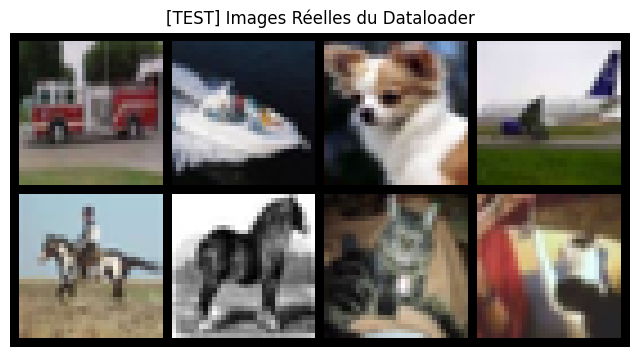

✅ [plot_images] Affichage terminé avec succès.


   -> Affichage des images fausses générées plus tôt pour vérifier...

🖼️ [plot_images] Début de l'affichage des images...
   ➤ Forme du batch d'images: torch.Size([4, 3, 32, 32])
   ➤ Type de données: torch.float32
   ➤ Appareil (device): cpu
   ➤ Dénormalisation des pixels de [-1, 1] vers [0, 1] pour l'affichage...
   ➤ Construction d'une grille d'images avec 4 image(s) par ligne...
   ➤ Conversion du tenseur PyTorch vers un format image (numpy)...
   ➤ Affichage avec Matplotlib...


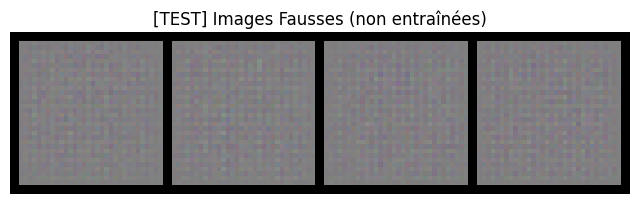

✅ [plot_images] Affichage terminé avec succès.


🖼️ [plot_images] Début de l'affichage des images...
   ➤ Forme du batch d'images: torch.Size([8, 3, 32, 32])
   ➤ Type de données: torch.float32
   ➤ Appareil (device): cpu
   ➤ Dénormalisation des pixels de [-1, 1] vers [0, 1] pour l'affichage...
   ➤ Construction d'une grille d'images avec 4 image(s) par ligne...
   ➤ Conversion du tenseur PyTorch vers un format image (numpy)...
   ➤ Affichage avec Matplotlib...


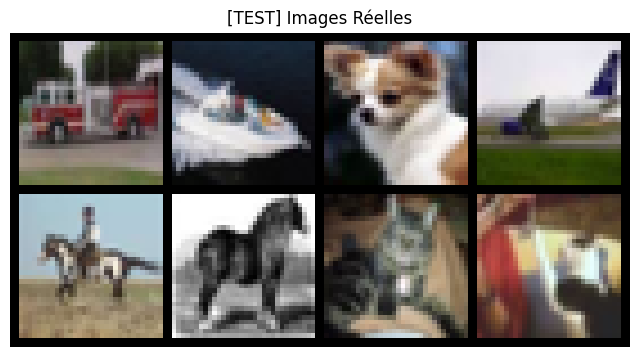

✅ [plot_images] Affichage terminé avec succès.


🖼️ [plot_images] Début de l'affichage des images...
   ➤ Forme du batch d'images: torch.Size([4, 3, 32, 32])
   ➤ Type de données: torch.float32
   ➤ Appareil (device): cpu
   ➤ Dénormalisation des pixels de [-1, 1] vers [0, 1] pour l'affichage...
   ➤ Construction d'une grille d'images avec 4 image(s) par ligne...
   ➤ Conversion du tenseur PyTorch vers un format image (numpy)...
   ➤ Affichage avec Matplotlib...


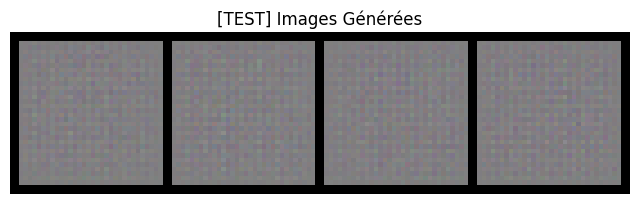

✅ [plot_images] Affichage terminé avec succès.


✅ [TEST 3/3] Succès ! Le chargement des données et l'affichage fonctionnent.

--- Nettoyage après la répétition générale... ---

✅ RÉPÉTITION GÉNÉRALE TERMINÉE AVEC SUCCÈS ! TOUT SEMBLE PRÊT !


In [19]:
# ==============================================================================
# 🔬 CELLULE 7: LA RÉPÉTITION GÉNÉRALE (SANITY CHECK)
# ==============================================================================
# On vérifie que tous nos instruments sont accordés avant le concert.

print("=" * 60)
print("🔬 DÉBUT DE LA RÉPÉTITION GÉNÉRALE (VÉRIFICATION DES COMPOSANTS)")
print("=" * 60)

# On va encapsuler chaque test dans un bloc try/except pour bien identifier d'où vient l'erreur si ça casse.

# --- TEST 1: Création des musiciens (les modèles) ---
print("\n--- [TEST 1/3] 🥁 Test de la création des modèles... ---")
try:
    print("   -> Demande à l'usine de créer un Générateur de test...")
    # On utilise les paramètres de base de notre config pour ce test.
    test_gen = create_generator(
        arch_name=config.generator_architectures[0],
        latent_dim=config.latent_dim_range[0],
        img_channels=config.img_channels,
        img_size=config.img_size
    ).to(config.device) # .to(device) envoie le modèle sur le GPU si disponible.
    print(f"   -> Générateur envoyé sur l'appareil: '{config.device}'")
    
    print("\n   -> Demande à l'usine de créer un Discriminateur de test...")
    test_disc = create_discriminator(
        arch_name=config.discriminator_architectures[0],
        img_channels=config.img_channels,
        img_size=config.img_size
    ).to(config.device)
    print(f"   -> Discriminateur envoyé sur l'appareil: '{config.device}'")
    
    print("\n✅ [TEST 1/3] Succès ! Les modèles ont été créés sans erreur.")
except Exception as e:
    print(f"\n❌ [TEST 1/3] ÉCHEC ! Une erreur est survenue lors de la création des modèles: {e}")
    # traceback.format_exc() donne une information très détaillée sur l'erreur.
    print(f"      Détails de l'erreur: {traceback.format_exc()}")
    # On arrête tout si cette étape échoue, car rien ne peut fonctionner sans les modèles.
    raise

# --- TEST 2: Le son (le forward pass) ---
print("\n--- [TEST 2/3] 🎶 Test du passage de données à travers les modèles (Forward Pass)... ---")
try:
    print(f"   -> Création d'un 'bruit' de départ (vecteur latent) factice de forme [4, {config.latent_dim_range[0]}]...")
    # On crée un batch de 4 vecteurs de bruit.
    test_z = torch.randn(4, config.latent_dim_range[0], device=config.device)
    print_tensor_info(test_z, "Bruit de départ (test_z)")
    
    print("\n   -> Passage du bruit à travers le Générateur pour créer de fausses images...")
    # On met le modèle en mode évaluation pour ce test.
    test_gen.eval() 
    with torch.no_grad(): # On désactive le calcul de gradient, c'est juste un test.
        fake_images = test_gen(test_z)
    print_tensor_info(fake_images, "Images générées (fake_images)")
    # On vérifie que la forme de sortie est correcte. C'est un test CRUCIAL.
    expected_shape = (4, config.img_channels, config.img_size, config.img_size)
    assert fake_images.shape == expected_shape, f"La forme des images générées est FAUSSE ! Attendu: {expected_shape}, Obtenu: {fake_images.shape}"
    print("      -> La forme des images générées est CORRECTE. C'est une excellente nouvelle !")

    print("\n   -> Passage des fausses images à travers le Discriminateur pour obtenir un score...")
    test_disc.eval()
    with torch.no_grad():
        predictions = test_disc(fake_images)
    print_tensor_info(predictions, "Prédictions du Discriminateur")
    # On vérifie que la sortie est bien un score par image.
    expected_pred_shape = (4, 1, 1, 1)
    assert predictions.shape == expected_pred_shape, f"La forme des prédictions est FAUSSE ! Attendu: {expected_pred_shape}, Obtenu: {predictions.shape}"
    print("      -> La forme des prédictions est CORRECTE. Le critique d'art fonctionne !")

    print("\n✅ [TEST 2/3] Succès ! Les données circulent correctement dans les deux modèles.")
except Exception as e:
    print(f"\n❌ [TEST 2/3] ÉCHEC ! Une erreur est survenue lors du forward pass: {e}")
    print(f"      Détails de l'erreur: {traceback.format_exc()}")
    raise

# --- TEST 3: La bibliothèque d'images (le Dataloader) et l'affichage ---
print("\n--- [TEST 3/3] 🖼️ Test du chargement des vraies images et de l'affichage... ---")
try:
    print("   -> Création d'un GANTrainer temporaire juste pour accéder à sa fonction get_dataloader...")
    # On a besoin d'un trainer pour créer un dataloader, car la logique est à l'intérieur.
    temp_trainer = GANTrainer(config)
    print("   -> Demande d'un lot (batch) de 8 images réelles...")
    test_loader = temp_trainer.get_dataloader(batch_size=8)
    # `next(iter( ... ))` est la façon de prendre le premier élément d'un itérateur comme un DataLoader.
    real_batch, real_labels = next(iter(test_loader))
    
    print("\n   -> Affichage des images réelles pour vérifier...")
    plot_images(real_batch, title="[TEST] Images Réelles du Dataloader")
    
    print("\n   -> Affichage des images fausses générées plus tôt pour vérifier...")
    # On doit les passer sur le CPU pour les afficher avec Matplotlib.
    plot_images(fake_images.cpu(), title="[TEST] Images Fausses (non entraînées)")


    
    plot_images(real_batch, title="[TEST] Images Réelles", nrow=4)
    plot_images(fake_images.cpu(), title="[TEST] Images Générées", nrow=4)

    print("\n✅ [TEST 3/3] Succès ! Le chargement des données et l'affichage fonctionnent.")
except Exception as e:
    print(f"\n❌ [TEST 3/3] ÉCHEC ! Une erreur est survenue avec le DataLoader ou l'affichage: {e}")
    print(f"      Détails de l'erreur: {traceback.format_exc()}")
    raise

# --- Nettoyage de la répétition ---
print("\n--- Nettoyage après la répétition générale... ---")
# On supprime les variables de test pour libérer de la mémoire, surtout sur le GPU.
del test_gen, test_disc, test_z, fake_images, temp_trainer, test_loader, real_batch, real_labels
cleanup_gpu_memory()

print("\n" + "=" * 60)
print("✅ RÉPÉTITION GÉNÉRALE TERMINÉE AVEC SUCCÈS ! TOUT SEMBLE PRÊT !")
print("=" * 60)